## Imports

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns 

# for importing apple data 
import xml.etree.ElementTree as ET

import functions
from importlib import reload
reload(functions)

import warnings
warnings.filterwarnings('ignore')

## Preparing the data 

#### Load and filter Xiaomi data

In [3]:
# order of people: Andy, Tom, Huub, Oumaima 

# Get data for each person
person1 = pd.read_csv('data/20231030_8210796956_MiFitness_hlth_center_fitness_data.csv')
person2 = pd.read_csv('data/20231030_8211531339_MiFitness_hlth_center_fitness_data.csv')
person3 = pd.read_csv('data/20231031_8210564343_MiFitness_hlth_center_fitness_data.csv')
person4 = pd.read_csv('data/20231110_8210586841_MiFitness_hlth_center_fitness_data.csv')

In [4]:
# Identify each person before combining all data into one big dataframe 
person1['Person ID'] = 1
person2['Person ID'] = 2
person3['Person ID'] = 3
person4['Person ID'] = 4

master_frame = pd.concat([person1, person2, person3, person4], ignore_index=True)


In [5]:
# Format all data from the keys to dataframes
key_dataframes = functions.format_mi_band_data(master_frame)


# relevant dataframes:
x_heart_rate_df = key_dataframes['heart_rate']
x_sleep_df = key_dataframes['watch_night_sleep']

In [6]:
# Get the data within our study time period

# 1696118399 = Saturday 30 September 2023 23:59:59 dit is de nacht voor de 1e keer dat we ontwaken
# 1697371200 = Sunday 15 October 2023 12:00:00 dit is de laatste keer dat we met een normale wekker (of smart wake voor tom) wakker worden
# 1698537599 = Saturday 28 October 2023 23:59:59 dit is de laatste dag dat we wakker worden

start_time = 1696118399
end_time = 1698537599

filtered_heart_rate_df = x_heart_rate_df[(x_heart_rate_df['Time'] >= start_time) & (x_heart_rate_df['Time'] <= end_time)]
filtered_watch_night_sleep_df = x_sleep_df[(x_sleep_df['Time'] >= start_time) & (x_sleep_df['Time'] <= end_time)]

#### Load and filter Apple data

In [7]:
# Load and parse the XML file
current_path = os.getcwd()
tree = ET.parse(current_path + '/data/export.xml')  
root = tree.getroot()

# Extract data into a list of dictionaries
data = []
for record in root.findall('Record'):
    record_data = record.attrib  # Extract attributes of the Record tag
    for metadata in record.findall('MetadataEntry'):
        record_data[metadata.get('key')] = metadata.get('value')
    data.append(record_data)

# Convert the list of dictionaries into a DataFrame
apple_df = pd.DataFrame(data)

In [8]:
apple_df['type'] = apple_df['type'].str.replace('HKQuantityTypeIdentifier', '')
apple_df['type'] = apple_df['type'].str.replace('HKCategoryTypeIdentifier', '')

# Filter for SleepAnalysis and HeartRate - relevant for our study
apple_df_filtered = apple_df[apple_df['type'].isin(['SleepAnalysis', 'HeartRate'])]

In [9]:
apple_df['creationDate'] = pd.to_datetime(apple_df['creationDate'])
apple_df['startDate'] = pd.to_datetime(apple_df['startDate'])
apple_df['endDate'] = pd.to_datetime(apple_df['endDate'])

# Filter for the time period
start_date = '2023-09-30'
end_date = '2023-10-28'
apple_df_filtered = apple_df_filtered[(apple_df_filtered['creationDate'] >= start_date) & (apple_df_filtered['creationDate'] <= end_date)]

##### Get apple heart rate dataframe

In [10]:
a_heart_rate_df = apple_df_filtered[apple_df_filtered['type'] == 'HeartRate']
a_heart_rate_df = a_heart_rate_df[['creationDate', 'startDate', 'endDate', 'value']]
a_heart_rate_df.head()

,creationDate,startDate,endDate,value
121528,2023-09-30 00:00:46 +0100,2023-09-29 23:49:49 +0100,2023-09-29 23:49:49 +0100,72
121529,2023-09-30 00:00:46 +0100,2023-09-29 23:54:35 +0100,2023-09-29 23:54:35 +0100,69
121530,2023-09-30 00:12:15 +0100,2023-09-29 23:59:35 +0100,2023-09-29 23:59:35 +0100,70
121531,2023-09-30 00:12:15 +0100,2023-09-30 00:04:34 +0100,2023-09-30 00:04:34 +0100,70
121532,2023-09-30 00:14:57 +0100,2023-09-30 00:09:45 +0100,2023-09-30 00:09:45 +0100,69


##### Get Apple sleep dataframe

In [11]:
a_sleep_df = apple_df_filtered[apple_df_filtered['type'] == 'SleepAnalysis']
# a_sleep_df.head()

In [12]:
# Convert startDate, endDate, and creationDate to datetime if not already done
a_sleep_df['startDate'] = pd.to_datetime(a_sleep_df['startDate'])
a_sleep_df['endDate'] = pd.to_datetime(a_sleep_df['endDate'])
a_sleep_df['creationDate'] = pd.to_datetime(a_sleep_df['creationDate'])

# Filter out 'HKCategoryValueSleepAnalysisInBed'
a_sleep_df = a_sleep_df[a_sleep_df['value'] != 'HKCategoryValueSleepAnalysisInBed']

# Define a function to categorize sleep states
def categorize_sleep_state(value):
    if 'Deep' in value:
        return 4
    elif 'REM' in value:
        return 2
    elif 'Core' in value:  # Assuming 'Core' is light sleep
        return 3
    elif 'Awake' in value:
        return 1
    else:
        return 'unknown'

# Categorize each record
a_sleep_df['sleep_state'] = a_sleep_df['value'].apply(categorize_sleep_state)

# Calculate the duration for each record in minutes
a_sleep_df['duration'] = (a_sleep_df['endDate'] - a_sleep_df['startDate']).dt.total_seconds() / 60

In [13]:
aggregated_data = []

# Process each day's data
for creation_date, day_data in a_sleep_df.groupby('creationDate'):
    # Ensure day_data is sorted by startDate to get the correct last record
    day_data_sorted = day_data.sort_values(by='startDate')

    # Fetch the wake-up time from the last record's creationDate
    wake_up_date = day_data_sorted['creationDate'].iloc[-1].date()
    wake_up_time = day_data_sorted['creationDate'].iloc[-1].time()

    # Calculate the total duration for each sleep state
    sleep_durations = day_data_sorted.groupby('sleep_state')['duration'].sum()

    day_summary = {
        'creation_date': creation_date,
        'wake_up_date': wake_up_date, 
        'wake_up_time': wake_up_time,
        'last_sleep_state': day_data_sorted['sleep_state'].iloc[-1],
        'sleep_deep_duration': sleep_durations.get(4, 0),  
        'sleep_light_duration': sleep_durations.get(3, 0),  
        'sleep_rem_duration': sleep_durations.get(2, 0),  
        'sleep_awake_duration': sleep_durations.get(1, 0), 
        'total_sleep_duration': sum(sleep_durations)
    }
    aggregated_data.append(day_summary)

# Convert the list of dictionaries to a DataFrame
a_sleep_df = pd.DataFrame(aggregated_data)


#### Load behaviour tracking data 

In [14]:
behaviour_tracking_data = pd.read_excel('data/Behavioural data app.xlsx')

#### Save all data for further preprocessing 

In [15]:
# Sleep xiaomi, heart xiaomi, sleep apple, heart apple
x_heart_rate_df.to_csv('data/x_heart_rate.csv', index=False)
x_sleep_df.to_csv('data/x_sleep.csv', index=False)

a_heart_rate_df.to_csv('data/a_heart_rate.csv', index=False)
a_sleep_df.to_csv('data/a_sleep.csv', index=False)

## Exploratory Data Analysis

Hier simpel houden, bij analysis meer diepgang:
- five nr summary per persoon voor heart and sleep data (boxplots)
- heart rate scatter plots general en during sleep 
- heart rate plots over time per persoon 
- binary variabelen distribution van waardes 

BPM

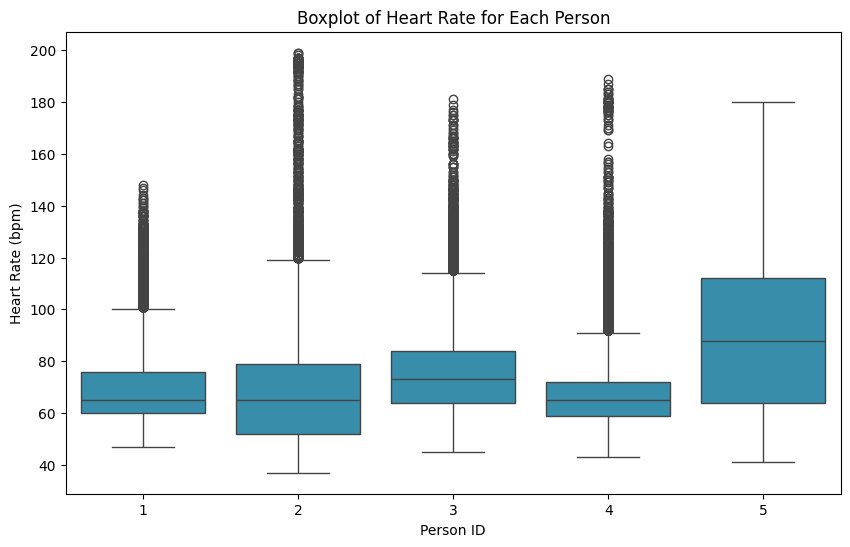

In [16]:
a_heart_rate_df['value'] = pd.to_numeric(a_heart_rate_df['value'])

plt.figure(figsize=(10, 6))

# Plot the boxplot for x_heart_rate_df
sns.boxplot(x='Person ID', y='bpm', data=x_heart_rate_df, color='#2596be')  # Set the color here

# Plot the boxplot for a_heart_rate_df with person number "5"
sns.boxplot(x=['5'] * len(a_heart_rate_df), y='value', data=a_heart_rate_df, color='#2596be', flierprops=dict(marker='D'))  

# Set labels and title
plt.xlabel('Person ID')
plt.ylabel('Heart Rate (bpm)')
plt.title('Boxplot of Heart Rate for Each Person')

# Show the plot
plt.show()

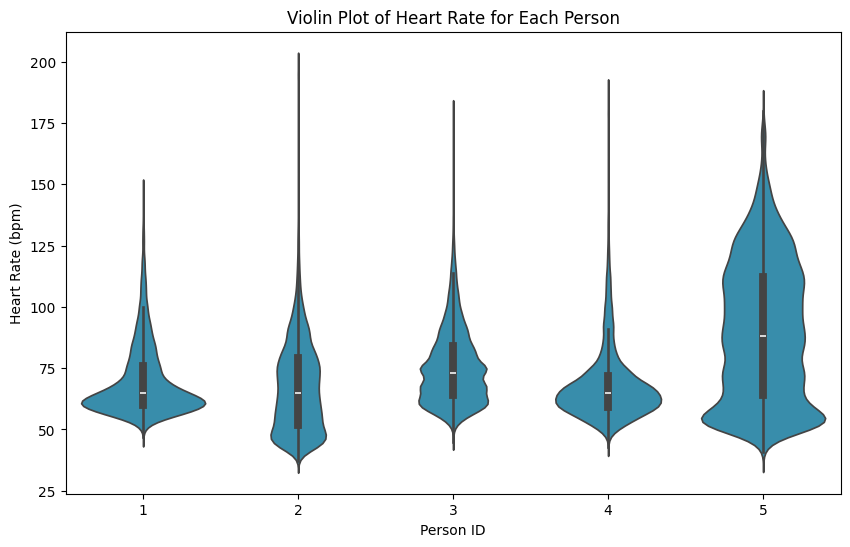

In [17]:
plt.figure(figsize=(10, 6))

# Plot the violin plot for x_heart_rate_df
sns.violinplot(x='Person ID', y='bpm', data=x_heart_rate_df, color='#2596be')  # Set the color here

# Plot the distribution for a_heart_rate_df with person number "5"
sns.violinplot(x=['5'] * len(a_heart_rate_df), y='value', data=a_heart_rate_df, color='#2596be')  # Set the color here

# Set labels and title
plt.xlabel('Person ID')
plt.ylabel('Heart Rate (bpm)')
plt.title('Violin Plot of Heart Rate for Each Person')

# Show the plot
plt.show()


Sleep 
- total duration 
- rem sleep duration 
- deep sleep duration 
- light sleep duration 
- awake duration 


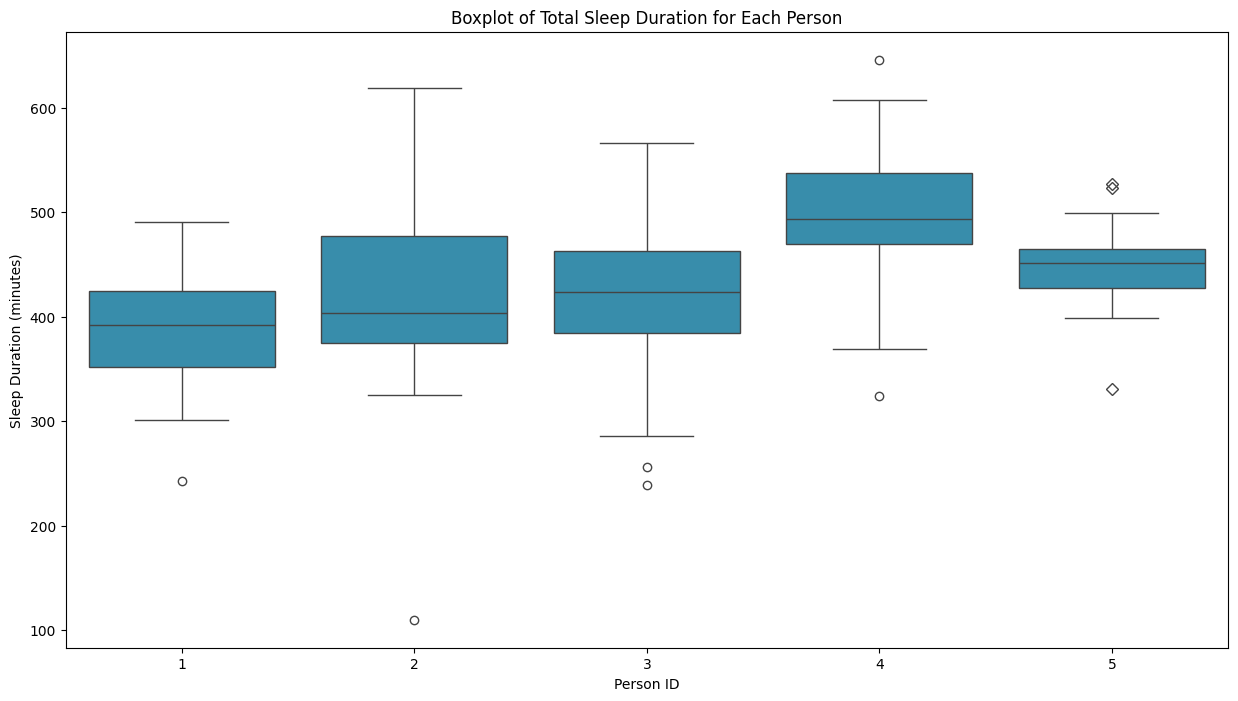

In [18]:
plt.figure(figsize=(15, 8))

# Plot the boxplot for sleep duration
sns.boxplot(x='Person ID', y='duration', data=x_sleep_df, color='#2596be')
sns.boxplot(x=['5'] * len(a_sleep_df), y='total_sleep_duration', data=a_sleep_df, color='#2596be', flierprops=dict(marker='D'))
plt.xlabel('Person ID')
plt.ylabel('Sleep Duration (minutes)')
plt.title('Boxplot of Total Sleep Duration for Each Person')
plt.show()

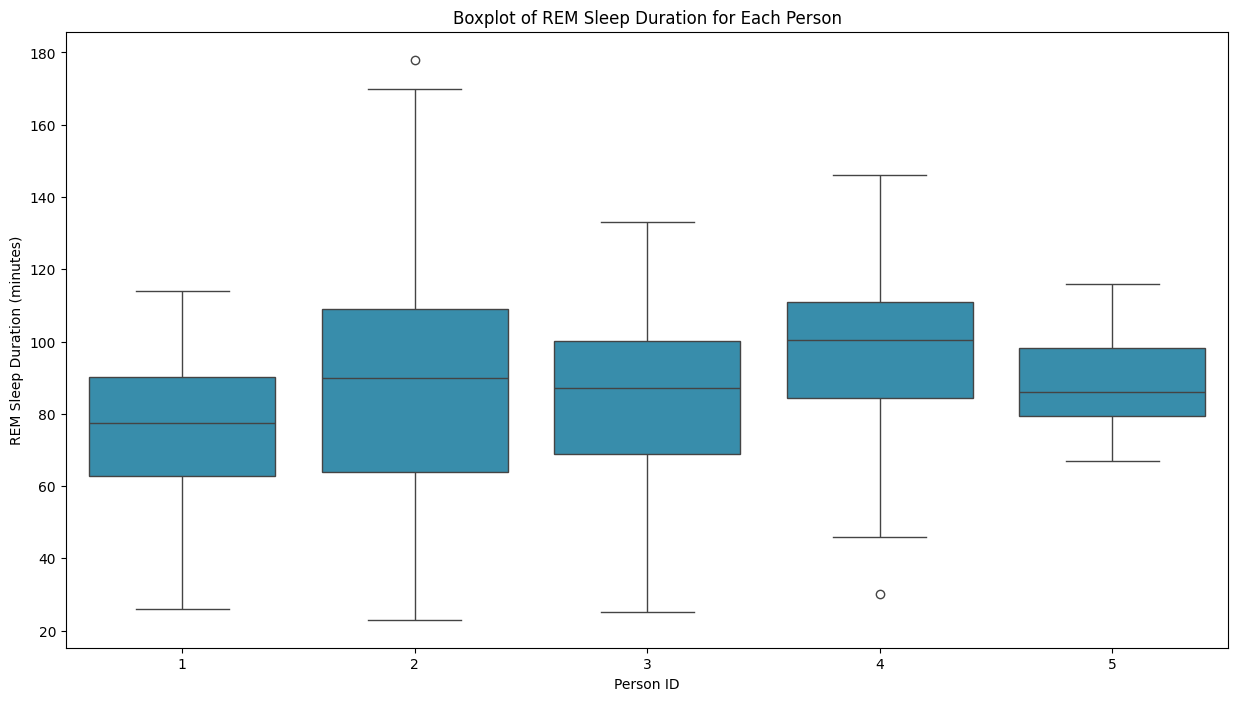

In [19]:
plt.figure(figsize=(15, 8))

# Plot the boxplot for REM sleep duration
sns.boxplot(x='Person ID', y='sleep_rem_duration', data=x_sleep_df, color='#2596be')
sns.boxplot(x=['5'] * len(a_sleep_df), y='sleep_rem_duration', data=a_sleep_df, color='#2596be', flierprops=dict(marker='D'))
plt.xlabel('Person ID')
plt.ylabel('REM Sleep Duration (minutes)')
plt.title('Boxplot of REM Sleep Duration for Each Person')
plt.show()

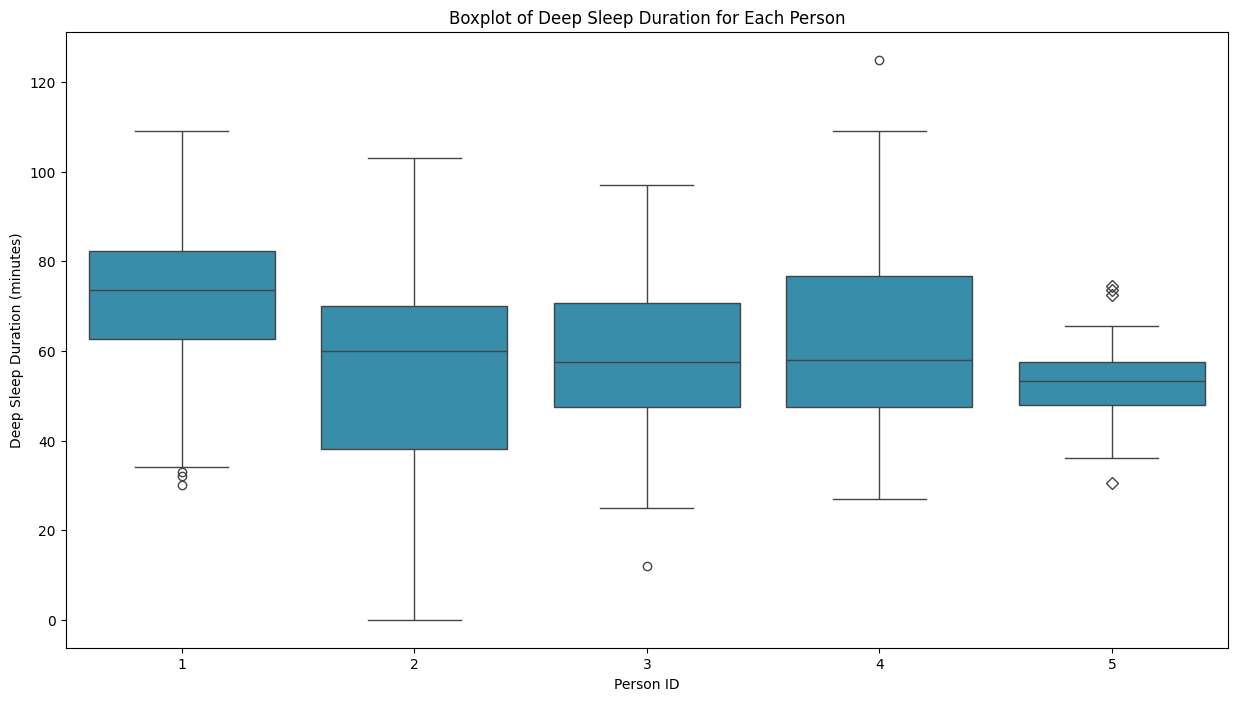

In [20]:
plt.figure(figsize=(15, 8))

# Plot the boxplot for deep sleep duration
sns.boxplot(x='Person ID', y='sleep_deep_duration', data=x_sleep_df, color='#2596be')
sns.boxplot(x=['5'] * len(a_sleep_df), y='sleep_deep_duration', data=a_sleep_df, color='#2596be', flierprops=dict(marker='D'))
plt.xlabel('Person ID')
plt.ylabel('Deep Sleep Duration (minutes)')
plt.title('Boxplot of Deep Sleep Duration for Each Person')
plt.show()

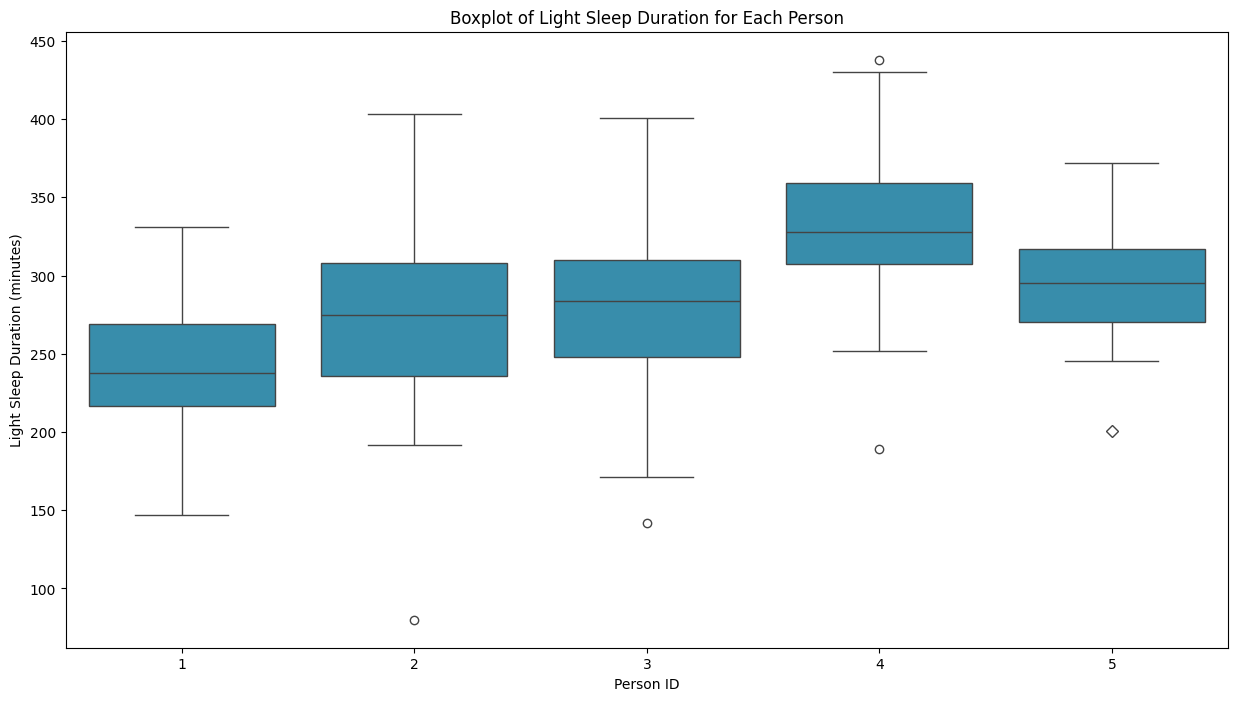

In [21]:
plt.figure(figsize=(15, 8))

# Plot the boxplot for light sleep duration
sns.boxplot(x='Person ID', y='sleep_light_duration', data=x_sleep_df, color='#2596be')
sns.boxplot(x=['5'] * len(a_sleep_df), y='sleep_light_duration', data=a_sleep_df, color='#2596be', flierprops=dict(marker='D'))
plt.xlabel('Person ID')
plt.ylabel('Light Sleep Duration (minutes)')
plt.title('Boxplot of Light Sleep Duration for Each Person')
plt.show()

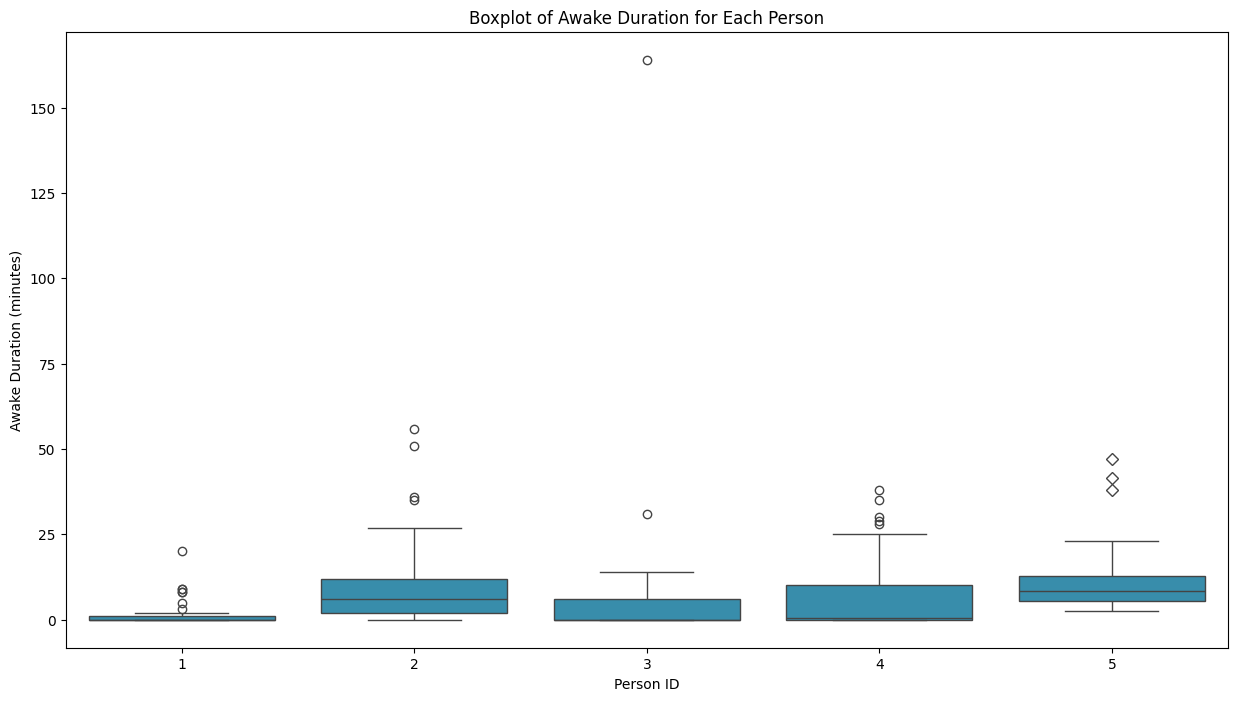

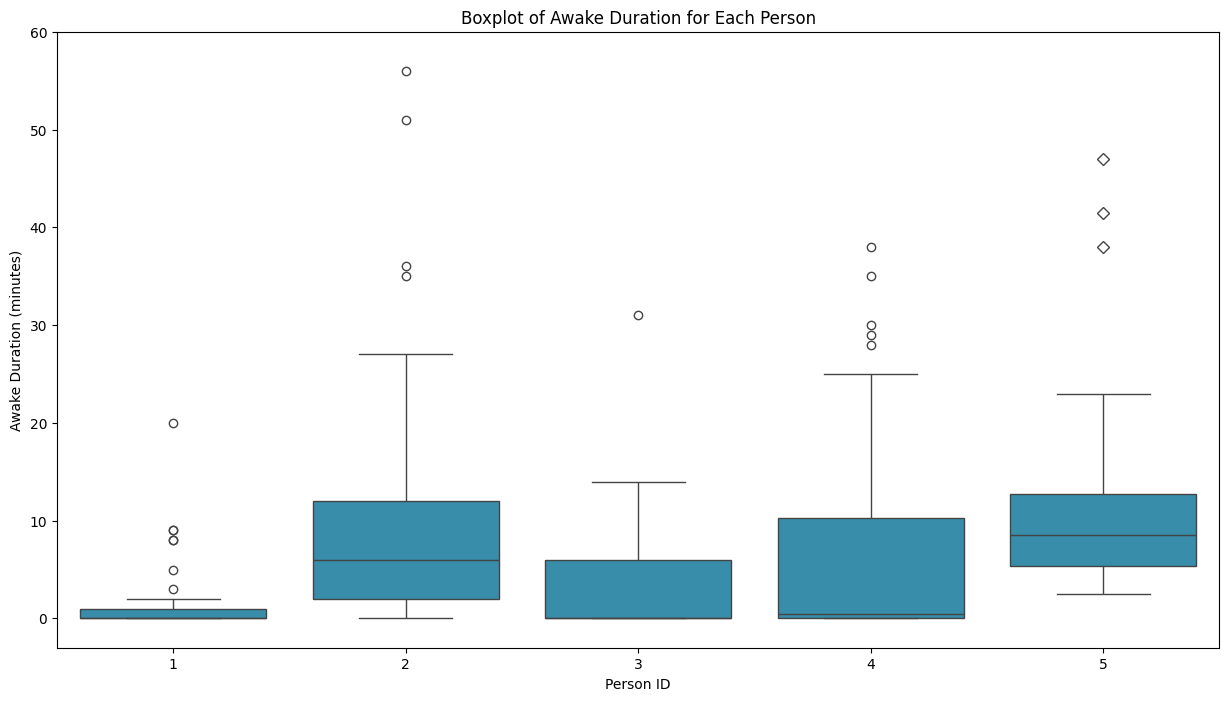

In [22]:
plt.figure(figsize=(15, 8))

# Plot the boxplot for awake duration
sns.boxplot(x='Person ID', y='sleep_awake_duration', data=x_sleep_df, color='#2596be')
sns.boxplot(x=['5'] * len(a_sleep_df), y='sleep_awake_duration', data=a_sleep_df, color='#2596be', flierprops=dict(marker='D'))
plt.xlabel('Person ID')
plt.ylabel('Awake Duration (minutes)')
plt.title('Boxplot of Awake Duration for Each Person')
plt.show()

plt.figure(figsize=(15, 8))

# Plot the boxplot for awake duration
sns.boxplot(x='Person ID', y='sleep_awake_duration', data=x_sleep_df, color='#2596be')
sns.boxplot(x=['5'] * len(a_sleep_df), y='sleep_awake_duration', data=a_sleep_df, color='#2596be', flierprops=dict(marker='D'))
plt.xlabel('Person ID')
plt.ylabel('Awake Duration (minutes)')
plt.title('Boxplot of Awake Duration for Each Person')
plt.ylim(-3, 60)
plt.show()


Sums of sleep durations per person

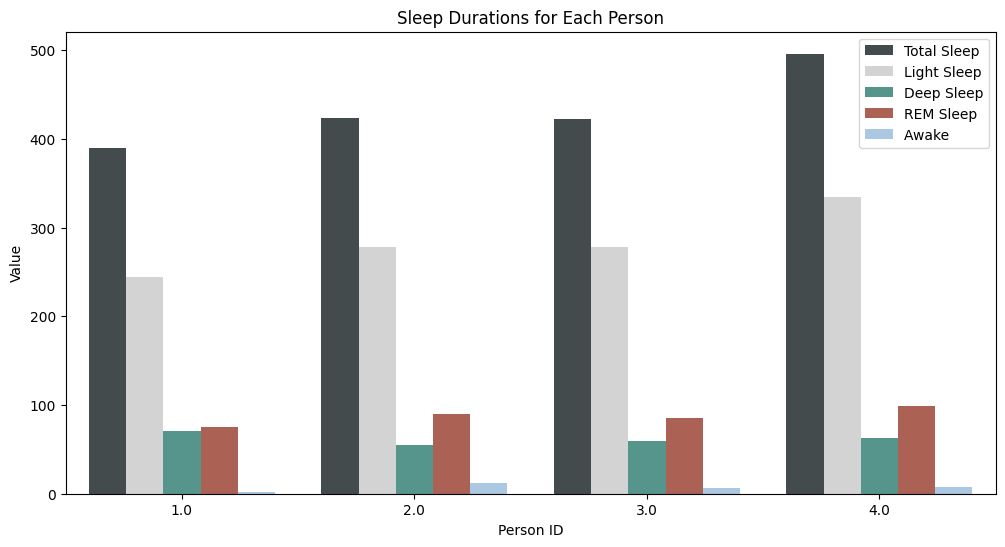

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming x_sleep_df and a_sleep_df are your DataFrames
persons = [1, 2, 3, 4, 5]

# Filter the data for the specified persons
x_filtered_data = x_sleep_df[x_sleep_df['Person ID'].isin(persons)]
a_filtered_data = a_sleep_df[a_sleep_df.index == 0]  # Assuming a_sleep_df has only one row for person 5

# Rename the total_sleep_duration column to 'duration'
a_filtered_data.rename(columns={'total_sleep_duration': 'duration'}, inplace=True)

# Combine the two datasets
combined_data = pd.concat([x_filtered_data, a_filtered_data])

# Melt the DataFrame for easier plotting
melted_data = combined_data.melt(id_vars=['Person ID'], value_vars=['duration', 'sleep_light_duration', 'sleep_deep_duration', 'sleep_rem_duration', 'sleep_awake_duration'])

# Rename the sleep-related variables for better legend labels
variable_names = {
    'duration': 'Total Sleep',
    'sleep_rem_duration': 'REM Sleep',
    'sleep_deep_duration': 'Deep Sleep',
    'sleep_light_duration': 'Light Sleep',
    'sleep_awake_duration': 'Awake '
}

# Map the variable names to the DataFrame
melted_data['variable'] = melted_data['variable'].map(variable_names)

# Create a grouped bar chart without confidence interval lines
plt.figure(figsize=(12, 6))
sns.barplot(x='Person ID', y='value', hue='variable', data=melted_data, palette=['#424c4eff', '#d3d3d3ff', '#4b9f94ff', '#ba5745ff', '#a2c8ecff'], ci=None)

# Adding labels and title
plt.xlabel('Person ID')
plt.ylabel('Value')
plt.title('Sleep Durations for Each Person')

# Move the legend to the upper right corner outside the plot area with smaller fontsize
plt.legend(loc='upper right')

# Show the plot
plt.show()


Heart rate scatter plots 


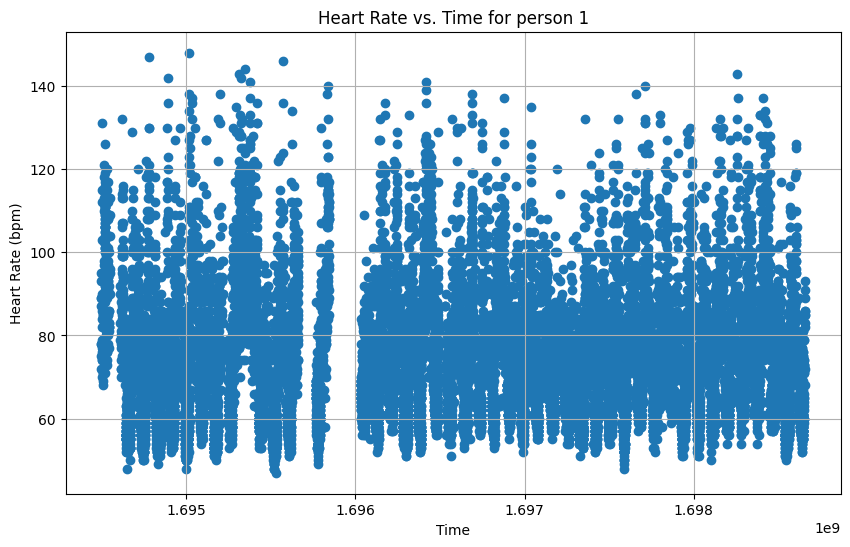

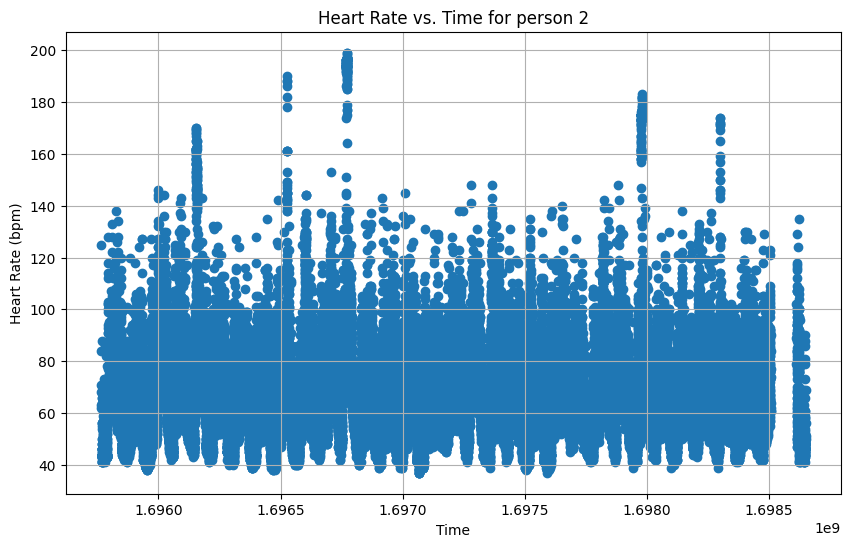

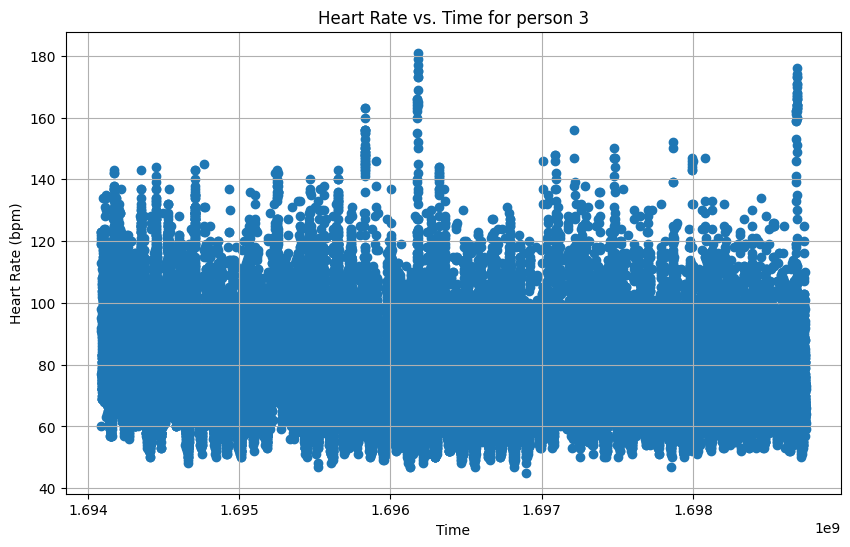

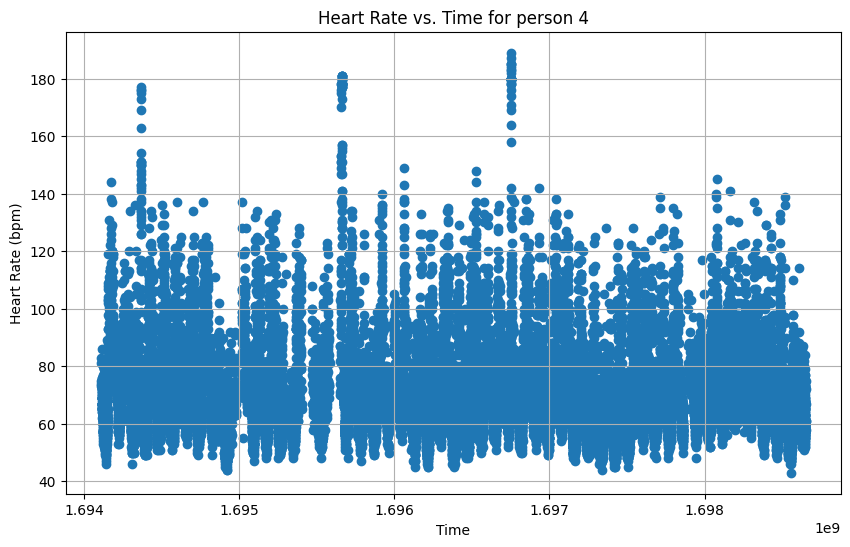

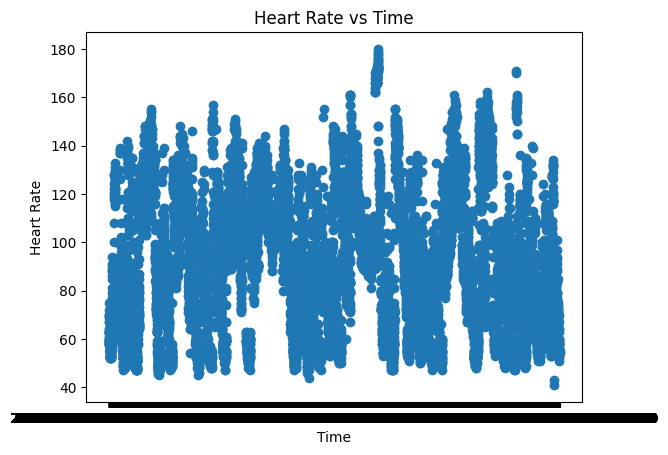

In [24]:
# Plot for each person separately
persons = x_heart_rate_df['Person ID'].unique()

for person in persons:
    person_data = x_heart_rate_df[x_heart_rate_df['Person ID'] == person]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(person_data['Time'], person_data['bpm'])
    
    plt.title(f'Heart Rate vs. Time for person {person}')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    
    plt.show()
    
plt.scatter(a_heart_rate_df['creationDate'], a_heart_rate_df['value'])
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate vs Time')
plt.show()
    
    

Heart rate over time

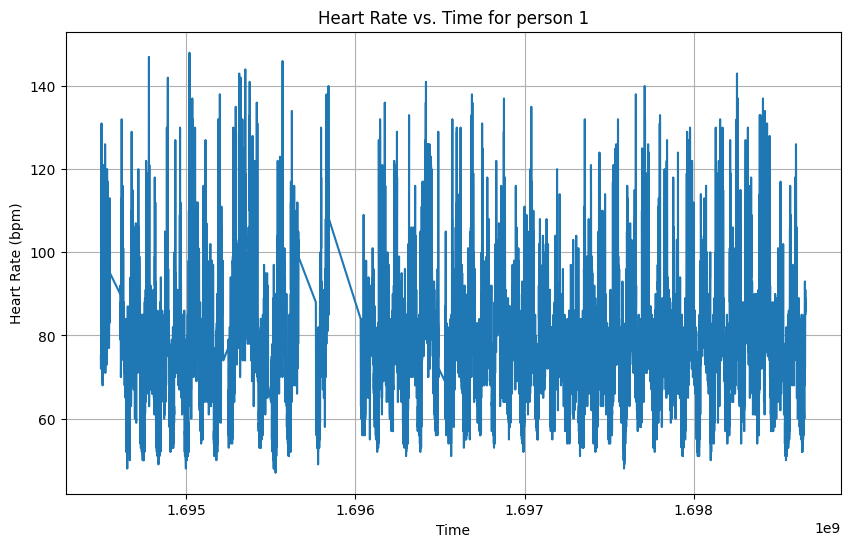

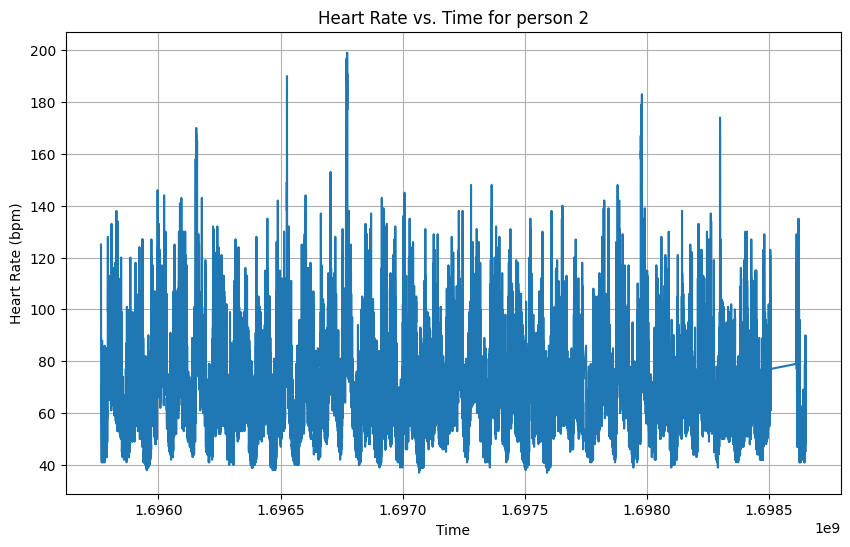

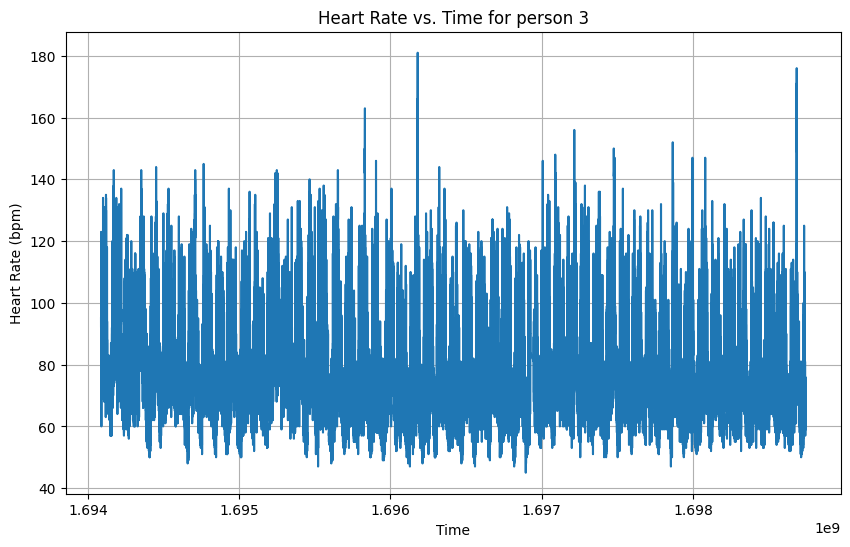

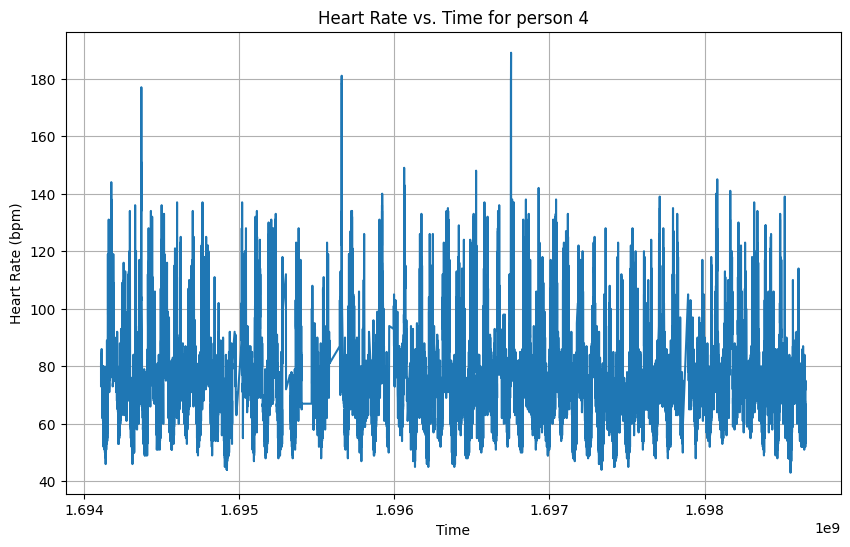

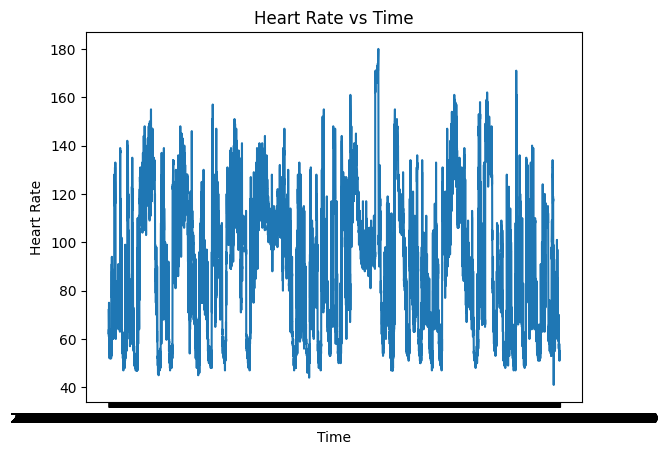

In [25]:
# Plot for each person separately
for person in persons:
    person_data = x_heart_rate_df[x_heart_rate_df['Person ID'] == person]
    
    plt.figure(figsize=(10, 6))
    plt.plot(person_data['Time'], person_data['bpm'])
    
    plt.title(f'Heart Rate vs. Time for person {person}')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    
    plt.show()
    

plt.plot(a_heart_rate_df['creationDate'], a_heart_rate_df['value'])
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate vs Time')
plt.show()


Behavioral data distribution

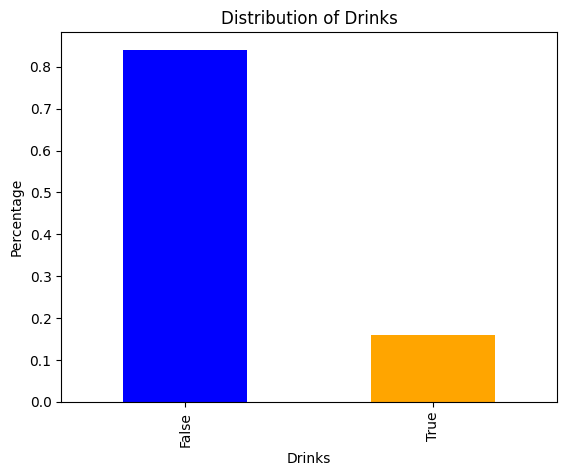

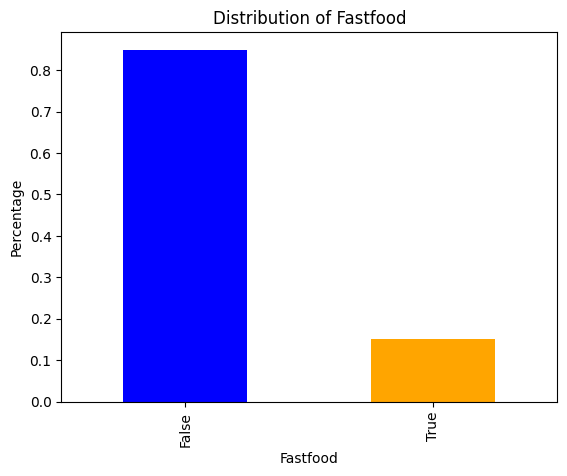

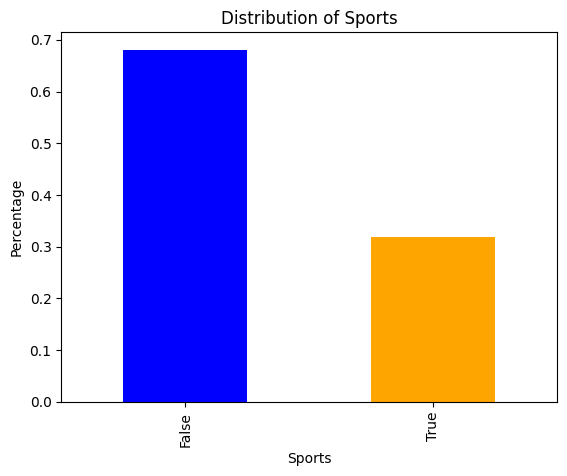

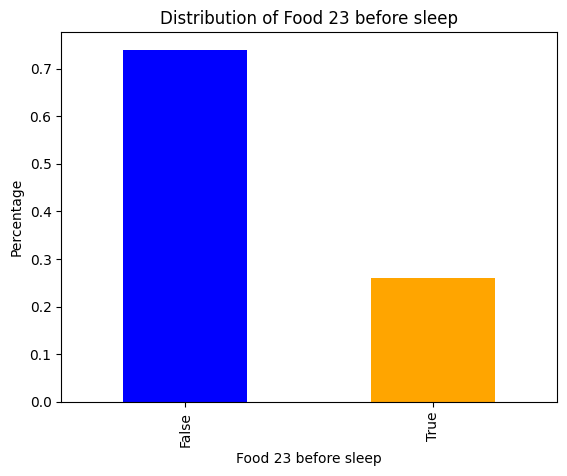

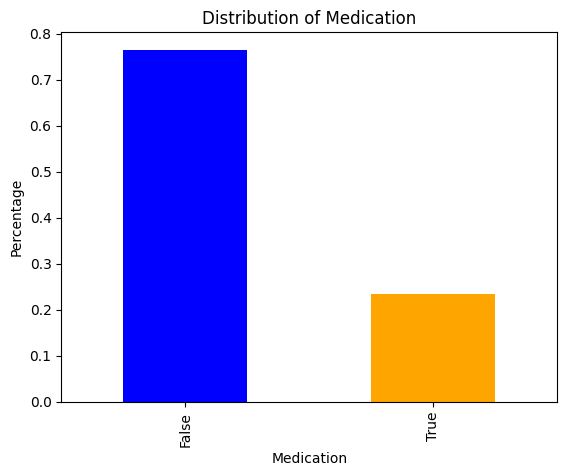

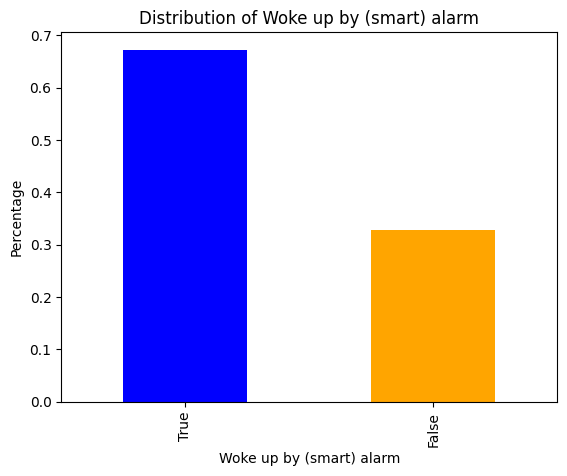

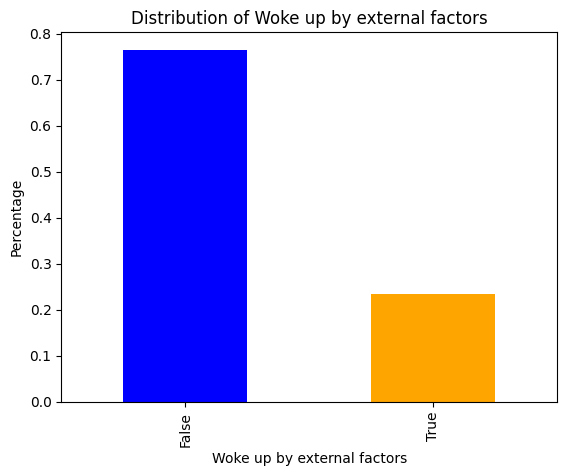

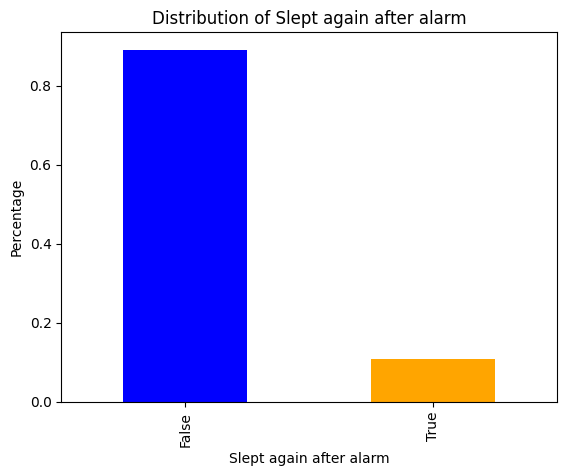

In [29]:
columns_to_exclude = ['Person ID', 'Date created', 'Yesterday', 'Smart alarm']  

for column in behaviour_tracking_data.columns:
    if column not in columns_to_exclude:
        distribution = behaviour_tracking_data[column].value_counts(normalize=True)
        distribution.plot(kind='bar', color=['blue', 'orange'])
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Percentage')
        plt.show()